In [1]:
import sys
import os
sys.path.append('..')
sys.path.append('../failure_directions')
import torch
import torchvision
import failure_directions
import numpy as np
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt


import failure_directions.src.svm_utils as svm_utils
import failure_directions.src.visualization_utils as viz_utils
import failure_directions.src.ds_utils as ds_utils
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from failure_directions.src.label_maps import CLASS_DICT
import pickle as pkl
from torchvision.datasets.folder import pil_loader

cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])
print(cifar_label_list)

/mnt/cfs/home/saachij/conda_envs/ffcv_cfs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [2]:
sns.set()
BLUE = sns.color_palette("tab10")[0]
RED = sns.color_palette("tab10")[3]
ORANGE = sns.color_palette("tab10")[1]
BROWN = sns.color_palette("tab10")[5]
GRAY = sns.color_palette("tab10")[7]
GREEN = sns.color_palette("tab10")[2]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (5, 3),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)


In [3]:
#Load SVM Model
beton_root = "/mnt/cfs/projects/correlated_errors/betons"
experiment_root = "/mnt/cfs/projects/correlated_errors/experiments/cifar/cifar_0.25"

svm_name = "svm_cifar_0.25_unlabeled_normalized"
name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}.pt") # SVM output file
svm_model_name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}_model.pkl") # SVM output file
model_root = os.path.join(experiment_root, "models")
model_ckpt = os.path.join(model_root, "cifar10_0.25_unlabeled/version_0/checkpoints/checkpoint_last.pt")
loss_upweight_root = os.path.join(experiment_root, "loss_vec_files")
subset_root = os.path.join(experiment_root, "subset_index_files")

%cd ../failure_directions
processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, get_unlabeled=True)
%cd ../analysis_nbs
svm_model = processor._build_model(model_ckpt)


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
-----------train_metrics--------------
{'Confusion Matrix': array([[ 439,  192],
       [3195, 6174]]),
 'Model Accuracy': 0.9369,
 'SVM Accuracy': 0.661300003528595,
 'SVM Balanced Accuracy': 0.6773514151573181}
-----------val_metrics--------------
{'Confusion Matrix': array([[1593,  415],
       [1713, 6279]]),
 'Model Accuracy': 0.7992,
 'SVM Accuracy': 0.7871999740600586,
 'SVM Balanced Accuracy': 0.7894936800003052}
-----------test_metrics--------------
{'Confusion Matrix': array([[1346,  749],
       [2007, 5898]]),
 'Model Accuracy': 0.7905,
 'SVM Accuracy': 0.724399983882904,
 'SVM Balanced Accuracy': 0.6942960917949677}
-----------unlabeled_metrics--------------
{'Confusion Matrix': array([[ 3972,  2185],
       [ 5945, 17898]]),
 'Model Accuracy': 0.7947666666666666,
 'SVM Accuracy': 0.7289999723434448,
 'SVM Balanced Accuracy': 0.6978899836540222}
Using default os_cache: False
Using default quasi_random: True
Us

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.60it/s]


Accuracy 0.953000009059906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.93it/s]


Accuracy 0.7991999983787537


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.74it/s]


Accuracy 0.7904999852180481


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 152.29it/s]


Accuracy 0.7947999835014343
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs
{'training_args': {'epochs': 35, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}, 'iters_per_epoch': 19}, 'epoch': 34, 'training_metrics': {'loss': 0.17487808826722598, 'acc': 0.9425370065789473}, 'val_metrics': {'loss': 0.6609623561382294, 'acc': 0.7992000002861023}}


In [4]:
processor.metrics['cv_scores']

[0.6642218046323067,
 0.7010094305812045,
 0.6696851119624674,
 0.6415698284604889,
 0.6484821828610479,
 0.6876278118609407,
 0.6769806482669898,
 0.6935678717699402,
 0.6241176656968883,
 0.6601421725872243]

In [5]:
split = 'test'
test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_correct = processor.metrics[f'{split}_metrics']['ytrue']

In [6]:
from failure_directions.src.config_parsing import ffcv_read_check_override_config
import yaml
%cd ../failure_directions
with open(processor.metrics['args']['config'], 'r') as file:
    fresh_hparams = yaml.safe_load(file)
fresh_hparams = ffcv_read_check_override_config(fresh_hparams)
%cd ../analysis_nbs


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs


## Get SVM Directions

In [7]:
# Get big CLIP features
hparams = processor.hparams
clip_processor = failure_directions.CLIPProcessor(ds_mean=hparams['mean'], ds_std=hparams['std'], arch='ViT-L/14')
clip_features = {}
for split, loader in processor.loaders.items():
    clip_features[split] = clip_processor.evaluate_clip_images(loader)

 29%|███████████▏                           | 255M/890M [00:05<00:13, 50.5MiB/s]


KeyboardInterrupt: 

In [ ]:
# svm_fitter = failure_directions.SVMFitter()
# svm_fitter.set_preprocess()
# val_gts, val_preds = processor.run_dict['val']['ys'], processor.run_dict['val']['preds']
# cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=clip_features['val'])

svm_fitter = failure_directions.SVMFitter()
svm_fitter.import_model("cifar_vit_L_svm.pt")

test_ys = processor.run_dict['test']['ys']
test_latents = clip_features['test']
big_clip_dv = svm_fitter.predict(ys=test_ys, latents=test_latents, compute_metrics=False)[1]

In [ ]:
import os
os.makedirs("cifar_large_directions")
for i in range(10):
    d = svm_fitter.clfs[i].coef_.squeeze(0)
    np.save(f"cifar_large_directions/dir{i}.npy", d/np.linalg.norm(d))

In [ ]:
from failure_directions.src.clip_utils import get_caption_set
captions = failure_directions.get_caption_set('CIFAR')
ref_captions = clip_processor.evaluate_clip_captions(captions['reference'])
np.save("cifar_large_directions/ref_captions.npy", ref_captions.numpy())

## Read the generated images

In [8]:
import src.stable_diffusion_utils as sd_utils
from src.stable_diffusion_utils import DiffDataset

In [9]:

path_dict = {
    'pos': sd_utils.get_sd_dict("/mnt/cfs/home/saachij/src/stable-diffusion/pos_sd", 10),
    'neg': sd_utils.get_sd_dict("/mnt/cfs/home/saachij/src/stable-diffusion/neg_sd", 10),
    'neutral': sd_utils.get_sd_dict("/mnt/cfs/home/saachij/src/stable-diffusion/neutral_sd", 10),
}

In [10]:
import torchvision.transforms as transforms
import torchvision
from failure_directions.src.decoders_and_transforms import PyTranslate, PyCutOut
hparams = processor.hparams

fill_color = tuple(map(int, hparams['mean']))

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    PyTranslate(2),
    PyCutOut(4, fill_color),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage()])
resize_base_transform = transforms.Compose([base_transform, transforms.Resize((32, 32))])
resize_train_transform = transforms.Compose([train_transform, transforms.Resize((32, 32))])
sd_ds = {
    k:  sd_utils.SDDataset(path_dict, name=k, num_imgs_per_class=100, transform=resize_base_transform)
    for k in ['pos', 'neg', 'neutral']
}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.83it/s]


In [10]:
def evaluate_model(model, loader):
    with torch.no_grad():
        with autocast():
            gts, preds, confs = [], [], []
            for x, y in tqdm(loader):
                x = x.cuda()
                logits = model(x)
                gts.append(y.cpu())
                preds.append(logits.argmax(-1).cpu())
                softmax_logits = nn.Softmax(dim=-1)(logits)
                confs.append(softmax_logits[torch.arange(logits.shape[0]), y].cpu())
    gts = torch.cat(gts)
    preds = torch.cat(preds)
    confs = torch.cat(confs)
    return gts, preds, confs

In [11]:
# See relative accuracies
def get_diff_predictions(name,target_class=None):
    base_ds = sd_ds[name]
    base_loader = torch.utils.data.DataLoader(base_ds, batch_size=100, shuffle=False, drop_last=False)
    gts, preds, confs = evaluate_model(svm_model, base_loader)
    if target_class is not None:
        mask = gts == target_class
        gts, preds, confs = gts[mask], preds[mask], confs[mask]
    return gts, preds, confs, (gts==preds).float().mean().item()

accs = {
    k: get_diff_predictions(name=k)[3]
    for k in  ['pos', 'neg', 'neutral']
}
print(accs)

100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


In [16]:
torchvision.ToPILImage()(INV_NORM(sd_ds['pos'][0][0]))

AttributeError: module 'torchvision' has no attribute 'ToPILImage'

In [12]:
print(accs)

{'pos': 0.6759999990463257, 'neg': 0.36899998784065247, 'neutral': 0.6850000023841858}


# Train models

In [33]:
bsz = fresh_hparams['batch_size']
ds_root = "/mnt/cfs/datasets/cifar"
orig_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=base_transform)
aug_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=train_transform)
test_ds = torchvision.datasets.CIFAR10(ds_root, train=False, transform=base_transform)

val_indices = processor.indices_dict['val_indices']
train_indices = processor.indices_dict['train_indices']
unlabeled_indices = processor.indices_dict['unlabeled_indices']


train_ds = torch.utils.data.Subset(aug_train_ds, train_indices)
val_ds = torch.utils.data.Subset(orig_train_ds, val_indices)
unlabeled_ds = torch.utils.data.Subset(aug_train_ds, unlabeled_indices)

no_aug_train_ds = torch.utils.data.Subset(orig_train_ds, train_indices)

# for unlabeled
# unlabeled_dv = processor.metrics[f'unlabeled_metrics']['decision_values']
# unlabeled_class = processor.metrics[f'unlabeled_metrics']['classes'] # 0 if female, 1 if male
# unlabeled_aug_inds = []
# unlabeled_K = 100
# for c in range(10):
#     mask = unlabeled_class == c
#     masked_indices = np.arange(len(unlabeled_class))[mask]
#     unlabeled_aug_inds.append(masked_indices[np.argsort(unlabeled_dv[mask])[:unlabeled_K]])
# unlabeled_aug_inds = np.concatenate(unlabeled_aug_inds)
# unlabeled_ds_for_aug = torch.utils.data.Subset(unlabeled_ds, unlabeled_aug_inds)
# sd_ds['unlabeled'] = unlabeled_ds_for_aug

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=True, drop_last=True)
no_shuffle_train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=bsz, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bsz, shuffle=False, drop_last=False)
no_aug_train_loader = torch.utils.data.DataLoader(no_aug_train_ds, batch_size=bsz, shuffle=False, drop_last=False)



In [32]:
import copy

def run_model(train_loader_, val_loader_, test_loader_, set_device=False):
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = build_fn(hparams['arch'], hparams['num_classes'])
    model = model.cuda()

    training_args=hparams['training']
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

def run_finetune_model(train_loader_, val_loader_, test_loader_, set_device=False, freeze=True):
    
    finetune_training = {
     'epochs': 15,
     'lr': 0.1,
     'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005},
     'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}
    }
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = copy.deepcopy(svm_model).train()
    
    if freeze:
        for name, p in model.named_parameters():
            if name.split('.')[0] != 'linear':
                print("freezing", name)
                p.requires_grad = False


    training_args=finetune_training
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

In [73]:
# See relative accuracies
#4
flip_interventions = {}
for k in ['pos', 'neg', 'neutral']:
# for k in ['unlabeled']:
    flip_interventions[k] = []
    for v in range(1):
        base_synth_dataset = sd_ds[k]
        synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
        synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
        flip_interventions[k].append(run_finetune_model(synth_train_loader, val_loader, test_loader, set_device=True, freeze=True))


freezing conv1.weight
freezing bn1.weight
freezing bn1.bias
freezing layer1.0.conv1.weight
freezing layer1.0.bn1.weight
freezing layer1.0.bn1.bias
freezing layer1.0.conv2.weight
freezing layer1.0.bn2.weight
freezing layer1.0.bn2.bias
freezing layer1.1.conv1.weight
freezing layer1.1.bn1.weight
freezing layer1.1.bn1.bias
freezing layer1.1.conv2.weight
freezing layer1.1.bn2.weight
freezing layer1.1.bn2.bias
freezing layer2.0.conv1.weight
freezing layer2.0.bn1.weight
freezing layer2.0.bn1.bias
freezing layer2.0.conv2.weight
freezing layer2.0.bn2.weight
freezing layer2.0.bn2.bias
freezing layer2.0.shortcut.0.weight
freezing layer2.0.shortcut.1.weight
freezing layer2.0.shortcut.1.bias
freezing layer2.1.conv1.weight
freezing layer2.1.bn1.weight
freezing layer2.1.bn1.bias
freezing layer2.1.conv2.weight
freezing layer2.1.bn2.weight
freezing layer2.1.bn2.bias
freezing layer3.0.conv1.weight
freezing layer3.0.bn1.weight
freezing layer3.0.bn1.bias
freezing layer3.0.conv2.weight
freezing layer3.0.bn

Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s, loss=0.43, acc=0.871] 


LR: 0.020000000000000004, Train Loss: 0.4191, Train Acc: 0.8808, Val Loss: 0.6863, Val Acc: 0.7984


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s, loss=0.433, acc=0.868]


LR: 0.04000000000000001, Train Loss: 0.4271, Train Acc: 0.8789, Val Loss: 0.6839, Val Acc: 0.7963


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s, loss=0.435, acc=0.864]


LR: 0.06000000000000001, Train Loss: 0.4153, Train Acc: 0.8783, Val Loss: 0.6776, Val Acc: 0.7954


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s, loss=0.416, acc=0.86] 


LR: 0.08000000000000002, Train Loss: 0.4113, Train Acc: 0.8800, Val Loss: 0.6718, Val Acc: 0.7938


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=0.395, acc=0.868]


LR: 0.1, Train Loss: 0.4146, Train Acc: 0.8761, Val Loss: 0.6591, Val Acc: 0.7951


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.387, acc=0.871]


LR: 0.09000000000000001, Train Loss: 0.4095, Train Acc: 0.8767, Val Loss: 0.6563, Val Acc: 0.7938


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.70it/s, loss=0.378, acc=0.871]


LR: 0.08000000000000002, Train Loss: 0.4045, Train Acc: 0.8795, Val Loss: 0.6563, Val Acc: 0.7938


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=0.345, acc=0.886]


LR: 0.06999999999999999, Train Loss: 0.4031, Train Acc: 0.8764, Val Loss: 0.6469, Val Acc: 0.7974


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=0.387, acc=0.871]


LR: 0.06, Train Loss: 0.3987, Train Acc: 0.8819, Val Loss: 0.6496, Val Acc: 0.7950


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.87it/s, loss=0.397, acc=0.871]


LR: 0.05, Train Loss: 0.3980, Train Acc: 0.8796, Val Loss: 0.6497, Val Acc: 0.7957


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.38, acc=0.875] 


LR: 0.039999999999999994, Train Loss: 0.3904, Train Acc: 0.8824, Val Loss: 0.6477, Val Acc: 0.7969


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.74it/s, loss=0.361, acc=0.882]


LR: 0.029999999999999995, Train Loss: 0.3954, Train Acc: 0.8836, Val Loss: 0.6473, Val Acc: 0.7981


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=0.395, acc=0.875]


LR: 0.019999999999999997, Train Loss: 0.3936, Train Acc: 0.8815, Val Loss: 0.6476, Val Acc: 0.7968


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=0.368, acc=0.879]


LR: 0.009999999999999988, Train Loss: 0.3943, Train Acc: 0.8815, Val Loss: 0.6482, Val Acc: 0.7983


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s, loss=0.372, acc=0.882]


LR: 0.0, Train Loss: 0.3896, Train Acc: 0.8807, Val Loss: 0.6457, Val Acc: 0.7978


100%|██████████| 20/20 [00:01<00:00, 10.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 57.06it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

consistent with old results 1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11961.98it/s]


dog
bird
automobile
airplane
truck
ship
frog
cat
horse
deer
reference
0.6642218046323067
performing classify captions on svm


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.68it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a red airplane inside', 'a photo of a red airplane',
       'a photo of a red airplane in the air',
       'a photo of a red airplane outside',
       'a photo of a red airplane flying',
       'a photo of a red airplane on a road',
       'a photo of a red airplane on the tarmac',
       'a photo of a airplane inside',
       'a photo of a orange airplane inside',
       'a photo of a orange airplane on a road'], dtype='<U50'),
 'neg_latents': array([[ 8.91113281e-02,  1.78710938e-01,  1.47705078e-01, ...,
        -2.55126953e-01,  2.15576172e-01,  1.80358887e-02],
       [ 1.57714844e-01,  1.50268555e-01,  2.18383789e-01, ...,
        -2.76367188e-01,  1.00769043e-01,  3.25202942e-04],
       [ 2.38525391e-01,  1.01623535e-01,  1.07360840e-01, ...,
        -2.62695312e-01,  2.40600586e-01, -1.24145508e-01],
       ...,
       [ 1.56005859e-01,  2.57080078e-01, -3.31115723e-03, ...,
        -2.81250000e-01,  2.72216797e-01, -2.03369141e-01],
       

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.52it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a automobile outside',
       'a photo of a automobile parked', 'a photo of a automobile inside',
       'a photo of a automobile', 'a photo of a brown automobile inside',
       'a photo of a brown automobile parked',
       'a photo of a brown automobile',
       'a photo of a brown automobile outside',
       'a photo of a green automobile inside',
       'a photo of a green automobile outside'], dtype='<U52'),
 'neg_latents': array([[ 0.07891846,  0.36645508, -0.05593872, ..., -0.22521973,
        -0.37817383, -0.14660645],
       [ 0.17382812,  0.2088623 ,  0.02426147, ..., -0.19006348,
        -0.52734375, -0.1538086 ],
       [ 0.02319336,  0.22021484, -0.2529297 , ..., -0.16711426,
        -0.32104492, -0.12371826],
       ...,
       [ 0.06677246,  0.3996582 ,  0.03091431, ..., -0.04257202,
        -0.41625977, -0.23498535],
       [-0.04025269,  0.19604492, -0.22167969, ...,  0.13232422,
        -0.25390625,  0.22509766],
       [ 0.0335083

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.26it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a bird flying', 'a photo of a white bird inside',
       'a photo of a white bird flying', 'a photo of a bird inside',
       'a photo of a white bird in the air',
       'a photo of a red bird flying', 'a photo of a orange bird flying',
       'a photo of a white bird', 'a photo of a bird in the air',
       'a photo of a yellow bird flying'], dtype='<U46'),
 'neg_latents': array([[ 0.35961914,  0.4831543 , -0.09765625, ..., -0.8256836 ,
         0.3635254 , -0.5957031 ],
       [ 0.04241943,  0.07232666,  0.07086182, ..., -0.31079102,
        -0.10949707, -0.39086914],
       [ 0.27734375,  0.32910156,  0.07312012, ..., -0.36816406,
         0.08679199, -0.8432617 ],
       ...,
       [ 0.07434082,  0.17321777,  0.1340332 , ..., -0.22253418,
        -0.1895752 , -0.5644531 ],
       [ 0.3659668 ,  0.41625977, -0.17248535, ..., -0.6928711 ,
         0.21972656, -0.5546875 ],
       [ 0.40795898,  0.37548828, -0.27441406, ..., -0.24475098,
         

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.69it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a white cat on the grass',
       'a photo of a red cat on the grass',
       'a photo of a blue cat on the grass',
       'a photo of a green cat on the grass',
       'a photo of a white cat on a green background',
       'a photo of a cat on the grass',
       'a photo of a red cat on a green background',
       'a photo of a blue cat on a green background',
       'a photo of a green cat in the forest',
       'a photo of a white cat in the forest'], dtype='<U45'),
 'neg_latents': array([[ 0.01927185, -0.28222656,  0.04138184, ..., -0.02952576,
        -0.32666016, -0.23205566],
       [ 0.01486206, -0.10961914,  0.03948975, ..., -0.27978516,
        -0.28125   ,  0.02877808],
       [ 0.05148315, -0.44970703, -0.14794922, ..., -0.08685303,
        -0.4477539 ,  0.3918457 ],
       ...,
       [ 0.04934692, -0.4873047 , -0.35888672, ...,  0.16381836,
        -0.36450195,  0.37768555],
       [ 0.04257202,  0.01248169, -0.28466797, ...,  0.0007782

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 123.86it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a blue deer in the snow',
       'a photo of a deer in the snow',
       'a photo of a brown deer in the snow',
       'a photo of a black deer in the snow',
       'a photo of a white deer in the snow',
       'a photo of a blue deer on a white background',
       'a photo of a brown deer on a white background',
       'a photo of a deer on a white background',
       'a photo of a black deer on a white background',
       'a photo of a red deer on a white background'], dtype='<U46'),
 'neg_latents': array([[ 0.08953857, -0.18151855, -0.06878662, ..., -0.0581665 ,
        -0.16723633, -0.29882812],
       [ 0.03320312, -0.05493164,  0.03387451, ..., -0.26904297,
        -0.02545166, -0.42138672],
       [ 0.1381836 , -0.03289795,  0.0859375 , ..., -0.10308838,
        -0.11895752, -0.5839844 ],
       ...,
       [-0.02026367, -0.06738281, -0.08660889, ..., -0.16442871,
        -0.03527832, -0.53271484],
       [ 0.21936035, -0.10229492, -0.24145508

pos: a photo of a green deer in a forest
neg: a photo of a blue deer in the snow
0.6876278118609407
performing classify captions on svm


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 144.47it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a black dog', 'a photo of a black dog outside',
       'a photo of a black dog inside',
       'a photo of a black dog in the forest',
       'a photo of a brown dog outside', 'a photo of a brown dog',
       'a photo of a black dog on a brown background',
       'a photo of a dog outside', 'a photo of a black dog in a house',
       'a photo of a black dog on a black background'], dtype='<U45'),
 'neg_latents': array([[ 0.30322266,  0.1282959 , -0.3786621 , ..., -0.22485352,
        -0.097229  ,  0.12890625],
       [ 0.2232666 ,  0.23742676, -0.38671875, ..., -0.21643066,
        -0.01754761,  0.19824219],
       [ 0.23474121,  0.01675415, -0.42138672, ..., -0.28881836,
        -0.00364685,  0.18493652],
       ...,
       [ 0.00201416,  0.33740234, -0.2927246 , ..., -0.5834961 ,
        -0.14245605,  0.13000488],
       [ 0.4663086 ,  0.01980591, -0.5395508 , ...,  0.05932617,
         0.09954834,  0.13293457],
       [ 0.11517334, -0.00881195, -0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 121.41it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a red frog outside', 'a photo of a red frog',
       'a photo of a red frog in a pond', 'a photo of a red frog inside',
       'a photo of a blue frog outside',
       'a photo of a brown frog outside',
       'a photo of a blue frog in a pond', 'a photo of a brown frog',
       'a photo of a blue frog inside',
       'a photo of a brown frog in a pond'], dtype='<U46'),
 'neg_latents': array([[-0.01174927,  0.07214355,  0.14648438, ...,  0.01852417,
         0.11486816, -0.25585938],
       [ 0.00996399,  0.06134033,  0.12054443, ...,  0.07067871,
        -0.03588867, -0.41259766],
       [-0.06054688,  0.2565918 ,  0.21923828, ...,  0.1772461 ,
         0.13122559, -0.34375   ],
       ...,
       [ 0.01928711,  0.22155762,  0.05871582, ...,  0.01478577,
        -0.11694336, -0.32861328],
       [-0.10137939, -0.17272949, -0.18273926, ...,  0.17272949,
        -0.10186768,  0.07080078],
       [-0.05615234,  0.38964844,  0.13806152, ...,  0.19482422

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 119.81it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a blue horse inside', 'a photo of a blue horse',
       'a photo of a blue horse on a green background',
       'a photo of a green horse inside',
       'a photo of a blue horse outside',
       'a photo of a blue horse on a blue background',
       'a photo of a green horse', 'a photo of a horse inside',
       'a photo of a blue horse on a white background',
       'a photo of a horse'], dtype='<U47'),
 'neg_latents': array([[ 0.05838013, -0.07336426, -0.25073242, ..., -0.24121094,
        -0.33935547,  0.23474121],
       [ 0.19396973, -0.09875488, -0.16015625, ..., -0.24633789,
        -0.42919922,  0.22167969],
       [ 0.14501953, -0.18103027, -0.2861328 , ...,  0.06152344,
        -0.16271973,  0.28857422],
       ...,
       [ 0.03053284, -0.03704834, -0.14343262, ..., -0.55859375,
        -0.0602417 ,  0.04876709],
       [ 0.11047363, -0.16320801, -0.31835938, ..., -0.17675781,
        -0.24975586, -0.34155273],
       [ 0.13708496,  0.101

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.15it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a blue ship inside',
       'a photo of a blue ship on the horizon', 'a photo of a blue ship',
       'a photo of a blue ship outside',
       'a photo of a blue ship in the ocean',
       'a photo of a blue ship on a blue background',
       'a photo of a blue ship on a green background',
       'a photo of a green ship on a blue background',
       'a photo of a green ship inside',
       'a photo of a blue ship on a black background'], dtype='<U46'),
 'neg_latents': array([[ 0.12225342, -0.11669922, -0.18005371, ..., -0.24304199,
        -0.05349731,  0.0692749 ],
       [ 0.18237305, -0.13537598, -0.03305054, ..., -0.31884766,
         0.02104187,  0.14428711],
       [ 0.22497559, -0.09136963, -0.08880615, ..., -0.27172852,
        -0.16027832,  0.05621338],
       ...,
       [ 0.30932617, -0.20458984, -0.28930664, ..., -0.0368042 ,
         0.06469727,  0.14355469],
       [ 0.06713867,  0.05282593, -0.27392578, ..., -0.13098145,
         0.18

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 144.91it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a 

{'neg_captions': array(['a photo of a blue truck on the road',
       'a photo of a orange truck on the road',
       'a photo of a blue truck inside',
       'a photo of a brown truck on the road',
       'a photo of a blue truck parked', 'a photo of a blue truck',
       'a photo of a brown truck on a blue background',
       'a photo of a orange truck on a blue background',
       'a photo of a orange truck inside',
       'a photo of a blue truck outside'], dtype='<U47'),
 'neg_latents': array([[ 0.15515137,  0.07885742,  0.08605957, ..., -0.0006237 ,
        -0.22790527,  0.21801758],
       [-0.07580566,  0.3564453 ,  0.20471191, ...,  0.03356934,
        -0.00040913, -0.24902344],
       [ 0.12353516,  0.0307312 , -0.04034424, ..., -0.17626953,
        -0.24194336,  0.16552734],
       ...,
       [ 0.1998291 ,  0.10614014, -0.07000732, ..., -0.00610352,
        -0.05584717, -0.11279297],
       [-0.09344482,  0.32958984,  0.14758301, ..., -0.1274414 ,
        -0.00969696, -0.31

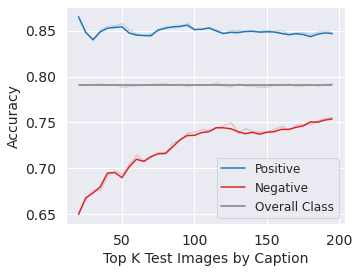

In [18]:
import src.clip_utils as clip_utils
cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])

clip_analyzer = viz_utils.ClipAnalyzer(
    processor=processor, svm_model_name=svm_model_name, caption_set_name="CIFARSIMPLE", class_names=cifar_label_list)

def get_cdf(arr, K_range=None):
    out = []
    if K_range is None:
        K_range = np.arange(10, len(arr), 10)
    for K in K_range:
        out.append(arr[:K].mean())
    out = np.array(out)
    return out, K_range

saved_caption_and_most_relevant_imgs = {}
all_dfs = []
for target_class in range(10):
    print(processor.metrics['cv_scores'][target_class])
    print("performing classify captions on svm")
    result = clip_analyzer.get_svm_style_top_K(target_class, 'all')
    print("--------")

    cdfs = {}
    class_mask = test_class==target_class
    masked_indices = np.arange(len(test_class))[class_mask]
    # K_range = np.arange(10, len(masked_indices), 10)
    K_range=np.arange(20, 200, 5)
    for caption_index in range(1):
        for direction in ['pos', 'neg']:
            caption_text = result[f'{direction}_captions'][caption_index]
            print(f"{direction}: {caption_text}")
            top_caption_latent = torch.tensor(result[f'{direction}_latents'][caption_index]).cuda()

            image_latents = clip_analyzer.clip_features['test'][class_mask].cuda()
            image_angles = clip_utils.order_descriptions_angle(mean_point=top_caption_latent.unsqueeze(0), query_points=image_latents)
            image_order = np.argsort(image_angles)[::-1]
            saved_caption_and_most_relevant_imgs[(target_class, caption_index, direction)] = (masked_indices[image_order], caption_text)
            dir_name = 'Positive' if direction == 'pos' else 'Negative' 
            cdfs[dir_name], _ = get_cdf(test_correct[masked_indices[image_order]], K_range)
            # uncomment this to display the images

        df = pd.DataFrame()
        df['Top K'] = K_range
        for d, v in cdfs.items():
            df[d] = v
        df['Overall Class'] = test_correct[masked_indices].mean()
        df = df.melt('Top K', var_name='Order', value_name='Accuracy')
        all_dfs.append(df)
    
combined_df = pd.concat(all_dfs).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.lineplot(data=combined_df, x='Top K', y='Accuracy', hue='Order', ax=ax, 
             hue_order=['Positive', 'Negative', 'Overall Class'], 
            palette=[BLUE, RED, GRAY], ci=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
ax.set_xlabel("Top K Test Images by Caption")
plt.savefig("figures/cifarsimple.pdf", bbox_inches='tight')
plt.show()
    

In [36]:
# flip_interventions = torch.load("/mnt/cfs/home/saachij/src/failure-directions/failure_directions/cifar_caption_level_imgs_2.pt")
# rdir = "/mnt/cfs/home/saachij/src/failure-directions/failure_directions/sd_files/cifar10/caption_level_no_freeze"
# base_name = 'cifar_caption_level_imgs_no_freeze'
# flip_interventions_ = [
#     torch.load(os.path.join(rdir, f"{base_name}_A.pt")),
#     torch.load(os.path.join(rdir, f"{base_name}_B.pt")),
#     torch.load(os.path.join(rdir, f"{base_name}_C.pt")),
#     torch.load(os.path.join(rdir, f"{base_name}_D.pt")),
#     torch.load(os.path.join(rdir, f"{base_name}_E.pt")),
# ]

In [43]:
# flip_interventions = torch.load("/mnt/cfs/home/saachij/src/failure-directions/failure_directions/cifar_caption_level_imgs_2.pt")
rdir = "/mnt/cfs/home/saachij/src/failure-directions/failure_directions/sd_files/cifar10/caption_level_freeze"
base_name = 'cifar_caption_level_imgs_freeze'
flip_interventions_ = [
    torch.load(os.path.join(rdir, f"{base_name}_A.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_B.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_C.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_D.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_E.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_G.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_H.pt")),
]

In [44]:
# mapping = {
#     'pos': 0,
#     'neg': 0.1,
#     'neutral': 0,
# }
mapping = {
    'pos': 'pos',
    'neg': 'neg',
    'neutral': 'neutral',
}
flip_interventions = {'pos': [], 'neg': [], 'neutral': []}
for f in flip_interventions_:
    for g in ['pos', 'neg', 'neutral']:
        for u in f[mapping[g]]:
            flip_interventions[g].append(u)

In [45]:

flip_int_corrects = {}
for k in flip_interventions:
    arr = flip_interventions[k]
    flip_int_corrects[k] = [arr[v][0] ==  arr[v][1] for v in range(len(arr))]

15


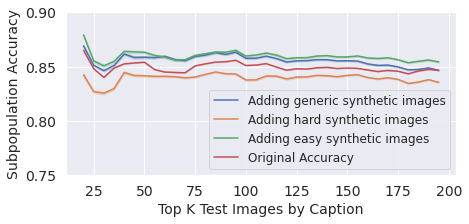

15


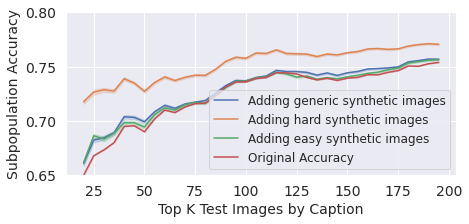

In [46]:
for POS_MODE in [True, False]:
    if POS_MODE:
        q_tag = 'pos'
    else:
        q_tag = 'neg'
    def get_dv_indices(target_c):
        dv = test_dv
        mask = test_class == target_c
        inds = np.arange(len(dv))[mask]
        return inds[np.argsort(dv[mask])]

    fig, ax_ = plt.subplots(1, 1, figsize=(7, 3))
    cls = -1
    trials = len(flip_int_corrects['pos'])
    print(trials)
    ax = ax_
    load_corrects = {
        'pos': flip_int_corrects['pos'],
        'neg': flip_int_corrects['neg'],
        'neutral': flip_int_corrects['neutral'],
        'baseline': [torch.tensor(test_correct == 1) for _ in range(trials)],

    }

    K = 100
    all_dfs = []
    if cls == -1:
        valid_classes = np.arange(10)
    else:
        valid_classes = [cls]
    for v in range(trials):
        xaxis = np.arange(20, 200, 5)
        accs = {k:[] for k in load_corrects.keys()}
        for K in xaxis:
    #         minority_indices = np.concatenate([get_dv_indices(target_c)[:K] for target_c in valid_classes])
            minority_indices = np.concatenate([saved_caption_and_most_relevant_imgs[(target_c, 0, q_tag)][0][:K] for target_c in valid_classes])
            for k in load_corrects.keys():
                accs[k].append(load_corrects[k][v][minority_indices].float().mean().item())
        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = accs['neutral']
        df['Adding hard synthetic images'] = accs['neg']
        df['Adding easy synthetic images'] = accs['pos']

        df['Original Accuracy'] = accs['baseline']
        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        all_dfs.append(df)


    all_df = pd.concat(all_dfs).reset_index()

    sns.lineplot(data=all_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    t = 'All' if cls == -1 else cifar_label_list[cls]  
    # ax.set_title(f'{t}')
    if POS_MODE:
        ax.set_ylim(0.75, 0.9)
    else:
        ax.set_ylim(0.65, 0.8)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc='lower right')
#     if POS_MODE:
#         plt.savefig('easy_finetune.pdf', bbox_inches='tight')
#     else:
#         plt.savefig('hard_finetune.pdf', bbox_inches='tight')
    plt.show()


In [40]:
for k in flip_interventions.keys():
    avg_accs = []
    for u in flip_interventions[k]:
        avg_accs.append((u[0] == u[1]).float().mean())
    print(k, np.mean(avg_accs))
print("original", (test_correct).mean())

pos 0.80056
neg 0.79992
neutral 0.80142003
original 0.7905


0.7905

In [19]:
for r in clip_analyzer.captions['reference']:
    print(r)
for c in range(10):
    print(saved_caption_and_most_relevant_imgs[(c, 0, 'neg')][1])

a photo of a airplane
a photo of a automobile
a photo of a bird
a photo of a cat
a photo of a deer
a photo of a dog
a photo of a frog
a photo of a horse
a photo of a ship
a photo of a truck
